Carga de librerías

In [1]:
# System management packages
import os
import re
import sys
import warnings
from numba import NumbaDeprecationWarning

sys.path.append('../src')
warnings.filterwarnings(action='ignore', category=NumbaDeprecationWarning)

# Data science packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Geospatial packages
import h3
import contextily
import geopandas as gpd
from shapely import Polygon
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster

# Personal packages
from settings import Settings
from ipywidgets import widgets

# Notebook settings
settings = Settings()

C:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\spaghetti\network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


# Selección de fuente de datos

In [2]:
# Data directory and list of files
DATA_BASE_DIR = os.path.join(settings.ROOT, 'data')
RAW_DATA = os.path.join(DATA_BASE_DIR, 'datos-produccion-maiz')
#PROCESSED_DATA = os.path.join(DATA_BASE_DIR, 'maize_production_h3hex_cells')

LIST_OF_FILES = [file for file in os.listdir(RAW_DATA) if file.startswith('agg')]
H3_CATALOGUE = pd.read_csv(os.path.join(RAW_DATA, '01_h3_cells_catalogue.csv'))
H3_RESOLUTION_LIST = [col for col in H3_CATALOGUE.columns if col.startswith('hex')]

# Declare file selector instance and mesh resolution
file_selector = widgets.Dropdown(
    options=LIST_OF_FILES
    ,description='Files'
    ,disabled=False)

# Display selectors
display(file_selector)

Dropdown(description='Files', options=('agg-maize-panel-rcp2p6.csv', 'agg-maize-panel-rcp8p5.csv'), value='agg…

In [3]:
# Store file_selector output in variable
file_path = os.path.join(RAW_DATA, file_selector.value)

# Extract AIRCCA base model and h3 mesh resolution
get_aircca_model = re.compile(r'rcp[0-9]p[0-9]')
model_pointer = get_aircca_model.search(file_path).group()

print(f'Model pointer: {model_pointer.upper()}')

Model pointer: RCP2P6


In [4]:
# Load data into dataframe object
data = (
    pd.read_csv(file_path)
    .join(
        other=H3_CATALOGUE[['id'] + H3_RESOLUTION_LIST]
        ,on='id'
        ,how='left'
        ,rsuffix='__ignore'))

# Drop __ignore and format column names
data.drop(
    columns=[col for col in data.columns if col.__contains__('__ignore')]
    ,inplace=True)

data.columns = [
    re.sub(
        pattern=r'[-\. ]'
        ,repl='_'
        ,string=colname.lower().strip())
    for colname in data.columns]

# List of ordinary predictors, non geographical nor temporal data
ordinary_predictors = [var for var in data.columns if var.startswith('mean')]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94224 entries, 0 to 94223
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             94224 non-null  int64  
 1   lon            94224 non-null  float64
 2   lat            94224 non-null  float64
 3   mean_precip    94224 non-null  float64
 4   mean_precip_2  94224 non-null  float64
 5   mean_temp      94224 non-null  float64
 6   mean_temp_2    94224 non-null  float64
 7   mean_yield     94224 non-null  float64
 8   period         94224 non-null  object 
 9   hex_0          94221 non-null  object 
 10  hex_1          94221 non-null  object 
 11  hex_2          94221 non-null  object 
 12  hex_3          94221 non-null  object 
 13  hex_4          94221 non-null  object 
 14  hex_5          94221 non-null  object 
 15  hex_6          94221 non-null  object 
 16  hex_7          94221 non-null  object 
 17  hex_8          94221 non-null  object 
 18  hex_9 

# Visualización inicial

In [5]:
def plot_yield_full_data(variable, period):
    # Visualization data
    _vis = (
        data
        .query(f"period == '{period}'"))

    # Figure config
    fig, ax = plt.subplots(figsize=(16,7))
    
    # Visualization elements
    map = ax.scatter(
        x=_vis.lon
        ,y=_vis.lat
        ,s=5
        ,c=_vis[variable]
        ,cmap='viridis')

    colorbar = plt.colorbar(map)
    
    # Annotations and styling
    ax.set_title(
        label=f'{model_pointer.upper()}, {period}: {variable}'
        ,fontsize=16)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)

    plt.show()

In [6]:
widgets.interact(
    plot_yield_full_data
    ,variable=widgets.Dropdown(
        options=ordinary_predictors
        ,value=ordinary_predictors[-1]
        ,description='Variable'
        ,disabled=False)
    ,period=widgets.Dropdown(
        options=data.period.unique()
        #,value=ordinary_predictors[-1]
        ,description='Period'
        ,disabled=False))

interactive(children=(Dropdown(description='Variable', index=4, options=('mean_precip', 'mean_precip_2', 'mean…

<function __main__.plot_yield_full_data(variable, period)>

# Visualización con h3-py

Revisar la siguiente [liga](https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb) para mayor detalle de las funcionalidades del framework de Uber.

Se empieza definiendo resoluciones de mallado para las celdas hexagonales

**IMPORTANTE**:

En la función `h3.latlng_to_cell(*, res)` el parámetro `res` pareciera que toma `res=15` como valor máximo, y no toma valores negativos. Pero el valor máximo pudiera deberse a recursos computacionales de mi máquina.

Adicionalmente, se define una función para extraer los polígonos asociados a cada uno de los hexágonos de la malla h3

In [7]:
def get_h3_polygon(row:str):
    points = h3.cell_to_boundary(
        h=row
        ,geo_json=True)

    return Polygon(points)

In [8]:
# Función de visualización interactiva
def plot_yield_h3(variable, resolution, period, basemap=False):
    _vis = (
        data
        .query(f"period == '{period}'")
        .filter(items=[resolution] + ordinary_predictors)
        # Group by hexagonal cell identifier
        .groupby(by=resolution)
        # Compute group sizes
        .mean()
        # Reset index for data processing
        .reset_index()
        # Compute groups centroids
        .assign(
            # Get centroid latitude
            lat = lambda _df: _df[resolution].apply(lambda row: h3.cell_to_latlng(row)[0])
            # Get centroid longitude
            ,lon = lambda _df: _df[resolution].apply(lambda row: h3.cell_to_latlng(row)[1])
            # Get h3 mesh polygons
            ,geometry = lambda _df: _df[resolution].apply(func=get_h3_polygon))
    )

    # Convert to geoDataFrame
    _vis = gpd.GeoDataFrame(data=_vis, crs='EPSG:4326')

    # Figure config
    fig, ax = plt.subplots(figsize=(16,7))
    
    # Visualization elements
    map = _vis.plot(
        column=variable
        ,legend=True
        ,ax=ax)

    # ---- Basemap
    if basemap:
        contextily.add_basemap(
            ax=ax
            ,crs=_vis.crs
            ,source=contextily.providers.CartoDB.PositronNoLabels)

    # Annotations and styling
    ax.set_title(
        label=f'{model_pointer.upper()}, {period}: {variable}'
        ,fontsize=16)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)

    plt.show()

In [9]:
widgets.interact(
    plot_yield_h3
    ,variable=widgets.Dropdown(
        options=ordinary_predictors
        ,value=ordinary_predictors[-1]
        ,description='Variable'
        ,disabled=False)
    ,resolution=widgets.Dropdown(
        options=H3_RESOLUTION_LIST
        ,value='hex_3'
        ,description='Resolution'
        ,disabled=False)
    ,period=widgets.Dropdown(
        options=data.period.unique()
        ,description='Period'
        ,disabled=False)
    ,basemap=widgets.Checkbox(
        value=False
        ,description='Basemap'
        ,disabled=False
        ,indent=True)
)

interactive(children=(Dropdown(description='Variable', index=4, options=('mean_precip', 'mean_precip_2', 'mean…

<function __main__.plot_yield_h3(variable, resolution, period, basemap=False)>

# Pruebas de hipótesis

Para mayor referencia de lo que se está desarrollando en esta sección, visitar el siguiente [_notebook_](https://github.com/CAMM961001/geospatial_data_science/blob/main/Chapter06/spatial_autocorrelation.ipynb)

## Autocorrelación espacial global

Primero se selecciona la resolución de malla hexagonal para la cual se hará el análisis. Sin embargo, para mantener consistencia con la estructura de datos del paper de AIRCCA, todos los periodos de tiempo se mantienen dentro de un mismo conjunto de datos para estratificar los análisis por esta categoría.

In [10]:
# Declare analysis resolution
h3_resolution_selector = widgets.Dropdown(
    options=[var for var in data.columns if var.startswith('hex')]
    ,value='hex_3'
    ,description='Resolutions'
    ,disabled=False)

# Display selectors
display(h3_resolution_selector)

Dropdown(description='Resolutions', index=3, options=('hex_0', 'hex_1', 'hex_2', 'hex_3', 'hex_4', 'hex_5', 'h…

In [11]:
# Analysis compression resolution
resolution = h3_resolution_selector.value

# Build analysis dataframe
train = (
    data
    # Filter h3 resolution for data compression
    .filter(items=['period', resolution] + ordinary_predictors)
    # Compute interactions columns and categories
    .assign(
        precip_temp = lambda _df: _df.mean_precip * _df.mean_temp
        ,period = lambda _df: pd.Categorical(_df.period))
    # Group by hexagonal cell identifier
    .groupby(by=['period', resolution])
    # Compute group sizes
    .mean()
    # Reset index for data processing
    .reset_index()
    # Compute groups centroids
    .assign(
        # Get centroid latitude
        lat = lambda _df: _df[resolution].apply(lambda row: h3.cell_to_latlng(row)[0])
        # Get centroid longitude
        ,lon = lambda _df: _df[resolution].apply(lambda row: h3.cell_to_latlng(row)[1])
        # Get h3 mesh polygons
        ,geometry = lambda _df: _df[resolution].apply(func=get_h3_polygon)))

# Convert to geoDataFrame
train = gpd.GeoDataFrame(data=train, crs=4326)

train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24630 entries, 0 to 24629
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   period         24630 non-null  category
 1   hex_3          24630 non-null  object  
 2   mean_precip    24630 non-null  float64 
 3   mean_precip_2  24630 non-null  float64 
 4   mean_temp      24630 non-null  float64 
 5   mean_temp_2    24630 non-null  float64 
 6   mean_yield     24630 non-null  float64 
 7   precip_temp    24630 non-null  float64 
 8   lat            24630 non-null  float64 
 9   lon            24630 non-null  float64 
 10  geometry       24630 non-null  geometry
dtypes: category(1), float64(8), geometry(1), object(1)
memory usage: 1.9+ MB


**Paso 1**: Una vez construido el _geoDataFrame_ de análisis, entonces ahora sí es posible seleccionar un periodo de interés

In [12]:
# Declare analysis resolution
period_selector = widgets.Dropdown(
    options=[var for var in train.period.cat.categories]
    ,description='Period'
    ,disabled=False)

# Display selectors
display(period_selector)

Dropdown(description='Period', options=('2005-2035', '2035-2065', '2065-2099'), value='2005-2035')

Se utiliza el estadístico _Moran's I_ de **autocorrelación espacial global** para probar la siguiente hipótesis:

* $H_0$: Los datos presentan aleatoriedad espacial.
* $H_1$: Los datos presentan algún tipo de estructura.

**Paso 2**: Construcción de matriz de pesos espaciales para un periodo dado

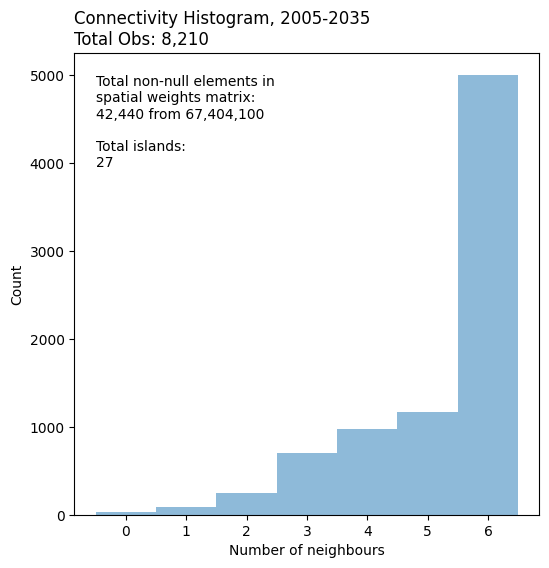

In [13]:
# Queen's contiguity spatial weights matrix
period = period_selector.value
W = train.query(f'period == "{period}"')
W = weights.Queen.from_dataframe(df=W, geom_col='geometry', silence_warnings=True)

# Spatial weights matriz row standarization
W.set_transform(value='R')

# Connectivity histogram data
_vis = np.array(W.histogram)

# Figure specs
fig, ax = plt.subplots(figsize=(6,6))

# Visualization elements
ax.bar(
    x=_vis[:,0]
    ,height=_vis[:,1]
    ,width=1
    ,color='tab:blue'
    ,alpha=0.5)

# Styling
ax.set_title(f'Connectivity Histogram, {period}\nTotal Obs: {W.n:,}', loc='left')
ax.set(
    xlabel='Number of neighbours'
    ,ylabel='Count'
    ,xticks=np.arange(0, int(W.max_neighbors)+1, 1))
ax.text(
    x=-0.5, y=_vis[:,1].max()
    ,s=f'Total non-null elements in\nspatial weights matrix:\n{W.sparse.nnz:,} from {W.n**2:,}\n\nTotal islands:\n{len(W.islands)}'
    ,horizontalalignment='left'
    ,verticalalignment='top')

plt.show()

**Paso 3**: Cálculo de rezago espacial para dispersión de Moran

In [14]:
# Spatial lag
lag_df = (
    train
    # Filter period
    .query(f'period == "{period}"')
    # Filter analysis colums
    .filter(items=['mean_yield','geometry'])
    .assign(
        # Scale variable of interes
        mean_yield_scaled = lambda _df: (_df.mean_yield - _df.mean_yield.mean()) / _df.mean_yield.std()
        # Spatial lag
        ,lag_scaled = lambda _df: weights.spatial_lag.lag_spatial(w=W, y=_df.mean_yield_scaled)))

# Preview
lag_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8210 entries, 0 to 8209
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   mean_yield         8210 non-null   float64 
 1   geometry           8210 non-null   geometry
 2   mean_yield_scaled  8210 non-null   float64 
 3   lag_scaled         8210 non-null   float64 
dtypes: float64(3), geometry(1)
memory usage: 320.7 KB


**Paso 4**: Evaluación de estadístico de prueba

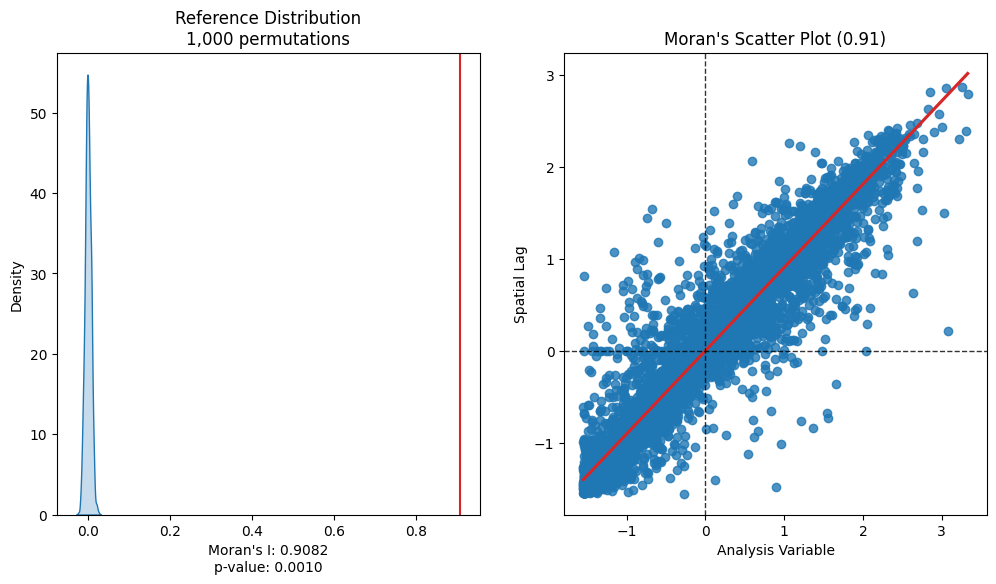

In [15]:
# Moran's I statistic instance
morans_stat = esda.moran.Moran(
    y=lag_df.mean_yield
    ,w=W
    ,transformation='R'
    ,permutations=1_000)

# Figure specs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# Visualization elements
sns.kdeplot(
    data=morans_stat.sim
    ,fill=True
    ,ax=ax[0])
ax[0].axvline(x=morans_stat.I, color='tab:red')
sns.regplot(
    data=lag_df
    ,x='mean_yield_scaled'
    ,y='lag_scaled'
    ,ci=None
    ,line_kws=dict(color='tab:red')
    ,ax=ax[1])
ax[1].axvline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')
ax[1].axhline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')


# Styling
ax[0].set(
    title=f'Reference Distribution\n{morans_stat.permutations:,} permutations'
    ,xlabel=f"Moran's I: {morans_stat.I:.4f}\np-value: {morans_stat.p_sim:.4f}"
    ,ylabel='Density')
ax[1].set(
    title=f"Moran's Scatter Plot ({morans_stat.I:.2f})"
    ,xlabel='Analysis Variable'
    ,ylabel='Spatial Lag')

plt.show()

## Autocorrelación espacial local

In [16]:
# Local Moran's I Statistic
price_lisa = esda.moran.Moran_Local(
    y=lag_df.mean_yield
    ,w=W
    ,transformation='R'
    ,permutations=1_000
    ,n_jobs=-1)

# Significance threshold
p = 0.01

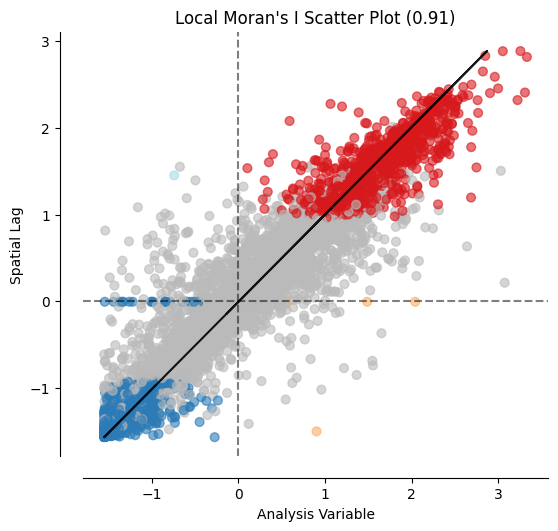

In [17]:
# Figure Specs
fig, ax = plt.subplots(figsize=(6,6))

# Visualization elements
moran_scatterplot(
    moran=price_lisa
    ,p=p
    ,ax=ax)

# Styling
ax.set(
    title=f"Local Moran's I Scatter Plot ({morans_stat.I:.2f})"
    ,xlabel='Analysis Variable'
    ,ylabel='Spatial Lag')

plt.show()

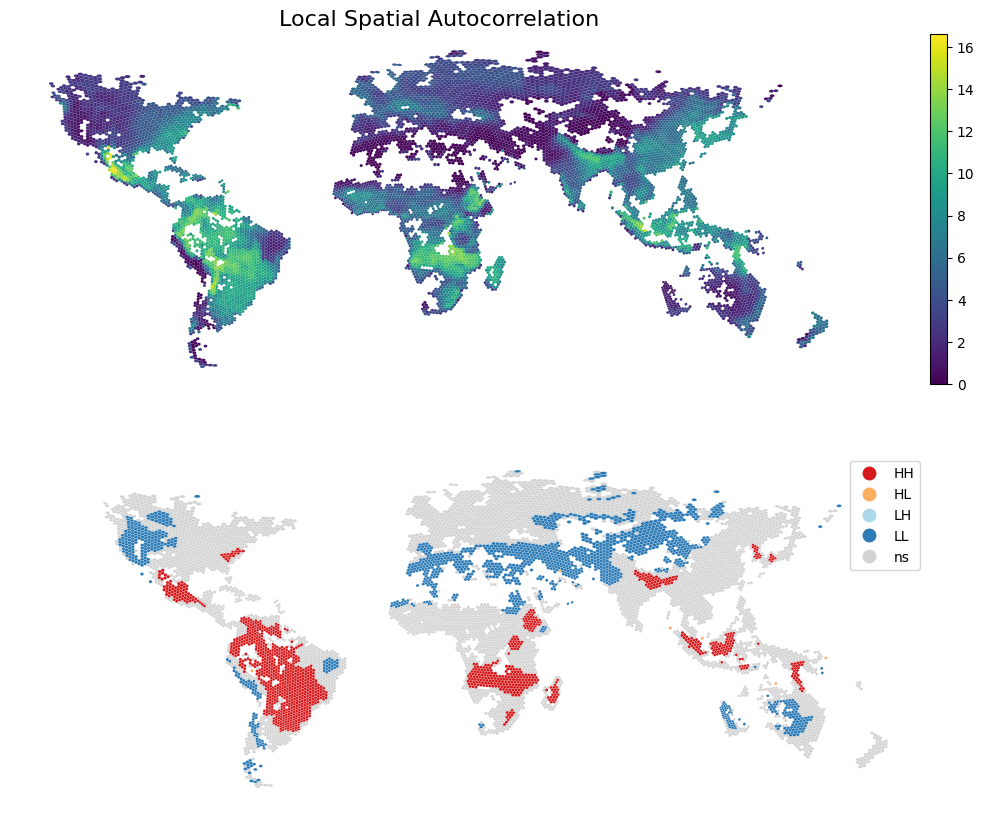

In [18]:
# Figure specs
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10))

# Visualization elements
lag_df.plot(
    column='mean_yield'
    ,legend=True
    ,ax=ax[0])
lisa_cluster(
    moran_loc=price_lisa
    ,gdf=lag_df
    ,p=p
    ,ax=ax[1])

# Styling
ax[0].set_title(
    label='Local Spatial Autocorrelation'
    ,fontsize=16)
ax[0].set_yticks([]), ax[1].set_yticks([])
ax[0].set_xticks([]), ax[1].set_xticks([])
ax[0].set_frame_on(False), ax[1].set_frame_on(False)

plt.show()

# Estrategias de modelado

El autor propone el siguiente modelo para la resolución del problema:

$$Y_{it} = C + \beta_1T_{it} + \beta_2T^2_{it} + \beta_3P_{it} + \beta_4P^2_{it} + \beta_5P_{it}T_{it} + \lambda_t + \alpha_i + u_{it}$$

En donde:

* $C$: Intercepto
* $T_{it}$: Temperatura del elemento $i$ al tiempo $t$
* $P_{it}$: Presipitación del elemento $i$ al tiempo $t$
* $\lambda_t$: Efectos fijos del periodo
* $\alpha_i$: Intercepto del elemento $i$
* $u_{it}$: Error del elemento $i$ al tiempo $t$